# Deep Q-Learning to collect yellow bananas using Dueling Networks

---

In this notebook, you will learn how to train an agent using Deep Q-Learning and Dueling networks.
### 1. Prepare 

Make sure, you followed the installation instructions which you can find in the [Readme](./Readme.md) of this repo.


In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np

#make sure, Environment is not going through proxy, when running on local machine
os.environ['NO_PROXY'] = 'localhost,127.0.0.*'

# define function for plotting scores
def plot(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Start environment

Next, we will prepare the environment!  **_Before running the code cell below_**, change the `file_name` to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

Please enter the corresponding value before executing the next cell...

In [8]:
file_name=r"Banana/Banana"
train_mode = True  # Whether to run the environment in training or inference mode
env_visible = True # Whether you want to see the agent doing training/inference.  

... now we can actually start the environment.

The UnityEnvironment launches and begins communication with the environment when instantiated.

Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling.

In [12]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name=file_name, base_port=64738, no_graphics=not env_visible)

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]
brain_name = env.brain_names[0]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Examine the state space

We can reset the environment to be provided with an initial set of observations and states for the agent within the environment. 

In [13]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.vector_observations[0]))
state_size = len(env_info.vector_observations[0])
print("\nState size is: \n{}".format(state_size))
action_size = brain.vector_action_space_size
print("\nActions size is: \n{}".format(action_size))


Agent state looks like: 
[1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]

State size is: 
37

Actions size is: 
4


#### Take Random Actions in the Environment

In the next code cell, we will use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for _ in range(100):                               # maximum 100 steps
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        env.reset(train_mode=False)[brain_name]
        break
    
print("Score: {}".format(score))

Score: 0.0


### Watch a Smart Agent!

In the next code cell, you will load trained weights from file to watch a smart agent!

In [15]:
from dqn_agent import Agent
import torch

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_vanilla.pth')) 

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]
    score = 0
    for _ in range(100):
        action = np.int32(agent.act(state))
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations[0]        # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward
        if done:
            env.reset(train_mode=False)[brain_name]
            break
    print("Run: {}, score: {}".format(i,score))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment

Run: 0, score: 3.0
Run: 1, score: 7.0
Run: 2, score: 7.0


# Train your own agent

## The Deep Q-Learning Algorithm: Deep Q-Learning with experience replay

So you want to train your own agent. Let's start with an introduction to the Deep Q-Learning algorithm. You can read more details [in this groundbreaking paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

### The algorithm

From the [paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

>The basic idea behind reinforcement learning is to estimate the action-value function using the Bellman equation as an iterative update \[...\]. Such value iteration algorithms converge to the optimal action-value function \[...\]. In practice, this basic approach is impractical, because the action-value function is estimated separately for each sequence, without any generalization. Instead, it is common to use a function approximator to estimate the action-value function.

In this implementation, you are using a neural network as function approximator. The weights of this neural network are updated at each learning step.

The agent does not only learn from random actions, but also from experiences.
After the agent takes a step in the environment, it's experiences (current state, action taken, reward, next state) at each timestep are stored in a dataset called experience buffer.

This is the implementation of the DQN algorithm.

In [16]:
import numpy as np
from collections import deque
from dqn_agent import Agent
import torch

def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.005, eps_decay=0.995, train_mode=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode, 
                     in case the agent gets stuck in a state
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    env_info = env.reset(train_mode=train_mode)[brain_name] #initialize environment

    for i_episode in range(1, n_episodes+1):
        state = env_info.vector_observations[0]
        score = 0
        for _ in range(max_t):
            action = np.int32(agent.act(state, eps))       # take an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done) #save experience in replay buffer & update weights
            state = next_state
            score += reward
            if done:
                env.reset(train_mode=train_mode)[brain_name]
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'my_checkpoint.pth')
            break
    return scores


#### Training the  agent 

We need to reset the environment and then reinitialize the agent. The environemtn is solved, when the agent reaches a score greater than or equal to 13.0 over the last 100 episodes. 

Episode 100	Average Score: 0.46
Episode 200	Average Score: 3.22
Episode 300	Average Score: 7.60
Episode 400	Average Score: 8.34
Episode 500	Average Score: 11.44
Episode 565	Average Score: 13.09
Environment solved in 465 episodes!	Average Score: 13.09
Duration: 0:15:16.452048


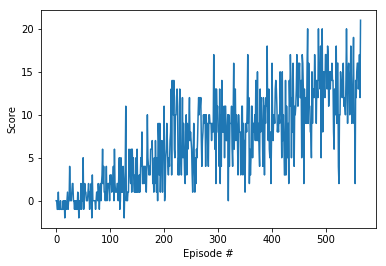

In [17]:
from datetime import datetime
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
start=datetime.now()
scores = dqn()
end=datetime.now()
print("Duration: {}".format(end-start))
plot(scores)
env.close()

## The neural network

The neural network used is a [duelling network](https://arxiv.org/abs/1511.06581)

The dueling network architecture represents two separate estimators: one for the state value function and one for the state-dependent action advantage function. According to the paper, the main benefit of this factoring is to generalize learning across actions without imposing any change to the underlying reinforcement learning algorithm. The results show that this architecture leads to better policy evaluation in the presence of many similar-valued actions.

The network consists of two fully connected layers (512 and 128 neurons), followed by two heads called advantage (128 and 128 neurons) and value (128 and 1 neuron).
The output is a q-value.



from [dqn_agent.py](./dqn_agent.py)
```python
   # Q-Network
   self.qnetwork_local = QNetwork(state_size, action_size, seed, 512, 128).to(device)

```


from [model.py](./model.py)

```python
def __init__():
  self.feature =nn.Sequential(
                nn.Linear(state_size, fc1_units),
                nn.SELU(), 
                nn.Linear(fc1_units, fc2_units),
                nn.SELU() 
  )
  
  self.advantage = nn.Sequential(
            nn.Linear(fc2_units, 128),
            nn.SELU(),
            nn.Linear(128, action_size)
  )
        
  self.value = nn.Sequential(
            nn.Linear(fc2_units, 128),
            nn.SELU(),
            nn.Linear(128, 1)
  )

```

This is how the two heads create one q-value from an advantage A(s,a) and a state value V(s).


```python
def forward(self, state):
    x = self.feature(state)
    advantage = self.advantage(x)
    value     = self.value(x)
    return value + advantage  - advantage.mean()
```

From the paper

> The proposed network architecture, which we name the dueling architecture, <i>explicitly separates the representation of
state values and (state-dependent) action advantages </i>. The
dueling architecture consists of two streams that represent
the value and advantage functions, while sharing a common convolutional feature learning module. The two streams
are combined via a special aggregating layer to produce an
estimate of the state-action value function Q \[...\]

## Additional Hyperparamters

You can find a set of hyperparameter that can be used to tune aspects of the training algorithm in the file [dqn_agent](./dqn_agent.py)

```python
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
```

I found that tuning these hyperparameters did not improve performance. 

# Further improvements

As you can see, I played around with different activation functions in the neural network, ending up with [SELU](https://arxiv.org/abs/1706.02515), which sometimes helped, solving the environment quicker.
Also using Huber loss improved performance on solving the environment.

As next steps I intend to implement [Prioritized experience replay](https://arxiv.org/abs/1511.05952).

Experience replay lets online reinforcement learning agents remember and reuse experiences from the past. Experience transitions are uniformly sampled from a replay memory.

However, this approach simply replays transitions at the same frequency that they were originally experienced, regardless of their significance. With prioritizing experience, important transitions are replayed more frequently, and therefore the agent can learn more efficiently.

I'd also be interested in how [Noisy nets](https://arxiv.org/abs/1706.10295) could improve performance, as the authors claim that <i>the induced stochasticity of the agent's policy can be used to aid efficient exploration</i>. This can be of help, because the trained agent gets stuck a lot of times within 100 episodes or less.


## Misc

You can run a non interactive version of the training from the commandline by running 

```python
python main.py
```

from the root of this repo (after [activating the environment](./readme.md)...)